# Logistic Regression - Basic CNTK Example

A feedforward neural network is an artificial neural network where connections between the units **do not** form a cycle. This is different from recurrent neural networks.

The feedforward neural network was the first and simplest type of artificial neural network devised. In this network, the information moves in only one direction, forward, from the input nodes, through the hidden nodes (if any) and to the output nodes. There are no cycles or loops in the network

<img src="https://upload.wikimedia.org/wikipedia/en/5/54/Feed_forward_neural_net.gif",width=150, height=150>


In [5]:
# Import the relevant components
import numpy as np
import sys
import os
from cntk import DeviceDescriptor, Trainer, sgd_learner, cntk_device, StreamConfiguration, text_format_minibatch_source
from cntk.ops import input_variable, cross_entropy_with_softmax, combine, classification_error, sigmoid
from cntk.ops import *

In [6]:
#Ensure we always get the same amount of randomness
np.random.seed(0)

# Define the network
input_dim = 2
num_output_classes = 2

In [7]:
#Helper function to generate a random data sample
def generate_random_data(sample_size, feature_dim, num_classes):
    # Create synthetic data using NumPy. 
    Y = np.random.randint(size=(sample_size, 1), low=0, high=num_classes)

    # Make sure that the data is separable
    X = (np.random.randn(sample_size, feature_dim)+3) * (Y+1)
    X = X.astype(np.float32)    
    # converting class 0 into the vector "1 0 0", 
    # class 1 into vector "0 1 0", ...
    class_ind = [Y==class_number for class_number in range(num_classes)]
    Y = np.asarray(np.hstack(class_ind), dtype=np.float32)
    return X, Y   

In [8]:
# Create the input variables denoting the features and the label data. Note: the input_variable does not need 
# additional info on number of observations (Samples) since CNTK first create only the network tooplogy first 
mysamplesize = 25
features, labels = generate_random_data(mysamplesize, input_dim, num_output_classes)
input = input_variable((input_dim), np.float32)
label = input_variable((num_output_classes), np.float32)

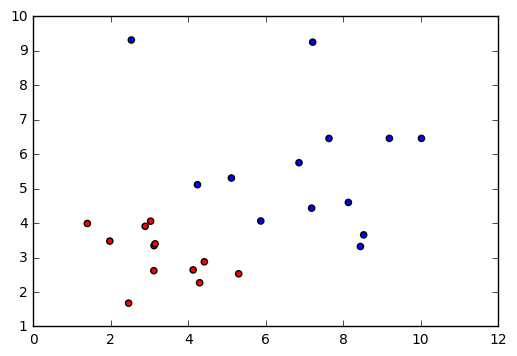

In [9]:
# Plot the data 
import matplotlib.pyplot as plt

#given this is a 2 class 
colors = ['b' if l == 0 else 'r' for l in labels[:,0]]

plt.scatter(features[:,0], features[:,1], c=colors)
plt.show()

In [12]:
# Set a fixed for reproducible runs
np.random.seed(1)

#Generate train and test data
trainsamplesize = 25
train_features, train_labels = generate_random_data(trainsamplesize, input_dim, num_output_classes)

testsamplesize = 10
test_features, test_labels = generate_random_data(testsamplesize, input_dim, num_output_classes)

#### Model parameters

A logistic regression (a.k.a LR) network is the simplest building block but has been powering hundereds of ML 
applications in the past decade. LR is a simple linear model that takes an input feature vector ($\bf{x}$) with 
dimensions (`input_dim`) say $m$) and emits the output a.k.a *evidence* ($\bf{z}$). 
Each feature in the input layer is connected with a output node by a corresponding weight w. 

The first step is to compute the evidence for an observation. Note: we use **bold** notations to denote vectors 
notation.

$$\bf{z} = \bf{w} \times \bf{x} + b$$ 

where $\bf{w}$ is the weight vector of lenght $n$ and $b}$ is a bias.  

### Network setup

The `linear_layer` function is pretty straight forward and should be easy to implement. We perform two operations:
0. multiply the weights ($\bf{w}$)  with the features ($\bf{x}$),
1. add the bias term $b$.

In [14]:
#QUESTION: input_var.output() construct is wierd; can we hide it

def linear_layer(input_var, output_dim):
    try:
        shape = input_var.shape()
    except AttributeError:
        input_var = input_var.output()
        shape = input_var.shape()

    input_dim = shape[0]
    times_param = parameter(shape=(input_dim, output_dim))
    bias_param = parameter(shape=(output_dim))

    t = times(input_var, times_param)
    return bias_param + t